In [63]:
suppressPackageStartupMessages({
library(tidyverse)
library(cowplot)
library(ggrepel)
library(pheatmap)
library(viridis)
library(matrixStats)
})
theme_set(theme_cowplot())
options(repr.plot.width=15,repr.plot.height=9)

# Mahjong Yaku stats

Analysis of yaku stats using [Tenhou](https://tenhou.net/) winning hands data, downloaded in may 2023

# the data

In [2]:
read_tsv("data/data.tsv.gz", col_types="") %>%
select(-hanp, -chanp, -rate) %>% 
complete(yaku, nesting(month, year, room, mode, total)) %>% 
mutate(count=ifelse(is.na(count), 0, count)) %>%
mutate(date=as.Date(paste0(year,'-',month,'-01'))) %>%
inner_join(read_tsv("data/rooms.tsv", col_types=""), by="room") %>%
inner_join(read_tsv("data/yakus.tsv", col_types=""), by='yaku') %>%
inner_join(read_tsv("data/modes.tsv", col_types=""), by='mode') %>%
mutate(yaku_romaji=str_to_title(yaku_romaji)) %>%
mutate(
    han_value_closed=case_when(
        grepl("yakuman", han_value_closed) ~ str_to_title(han_value_closed),
        TRUE ~ paste(han_value_closed, "Han")
    )
) %>%
mutate(
    han_value_closed=ordered(han_value_closed, levels=c("1 Han", "2 Han", "3 Han", "6 Han", "Yakuman", "Double Yakuman"))
) -> a
head(a)

yaku,month,year,room,mode,total,count,avg_yaku_han,avg_hand_han,date,room_romaji,yaku_romaji,han_value_closed,mode_romaji,n_players,n_rounds
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<chr>,<chr>,<ord>,<chr>,<dbl>,<dbl>
ドラ,1,2007,一般,三南喰赤,39157,30121,2.15,5.66,2007-01-01,ippan,Dora,1 Han,sanma hanchan kui-aka,3,6
ドラ,1,2007,一般,三東喰赤,11204,8563,2.15,5.67,2007-01-01,ippan,Dora,1 Han,sanma tonpu kui-aka,3,3
ドラ,1,2007,一般,南,21206,8127,1.56,3.93,2007-01-01,ippan,Dora,1 Han,hanchan,4,8
ドラ,1,2007,一般,南喰,14760,5760,1.56,3.77,2007-01-01,ippan,Dora,1 Han,hanchan kui,4,8
ドラ,1,2007,一般,南喰赤,43756,16592,1.58,4.39,2007-01-01,ippan,Dora,1 Han,hanchan kui-aka,4,8
ドラ,1,2007,一般,東,46241,17642,1.57,3.93,2007-01-01,ippan,Dora,1 Han,tonpu,4,4


In [3]:
select(a, year, month, room, mode, total) %>% unique() %>% with(sum(total))

[1] 1416125478

* the data contains frequency of yakus in all winning hands played on tenhou since 2007
* the data is aggregated by month, room rank and game type, totalling 1.4 billion winning hands

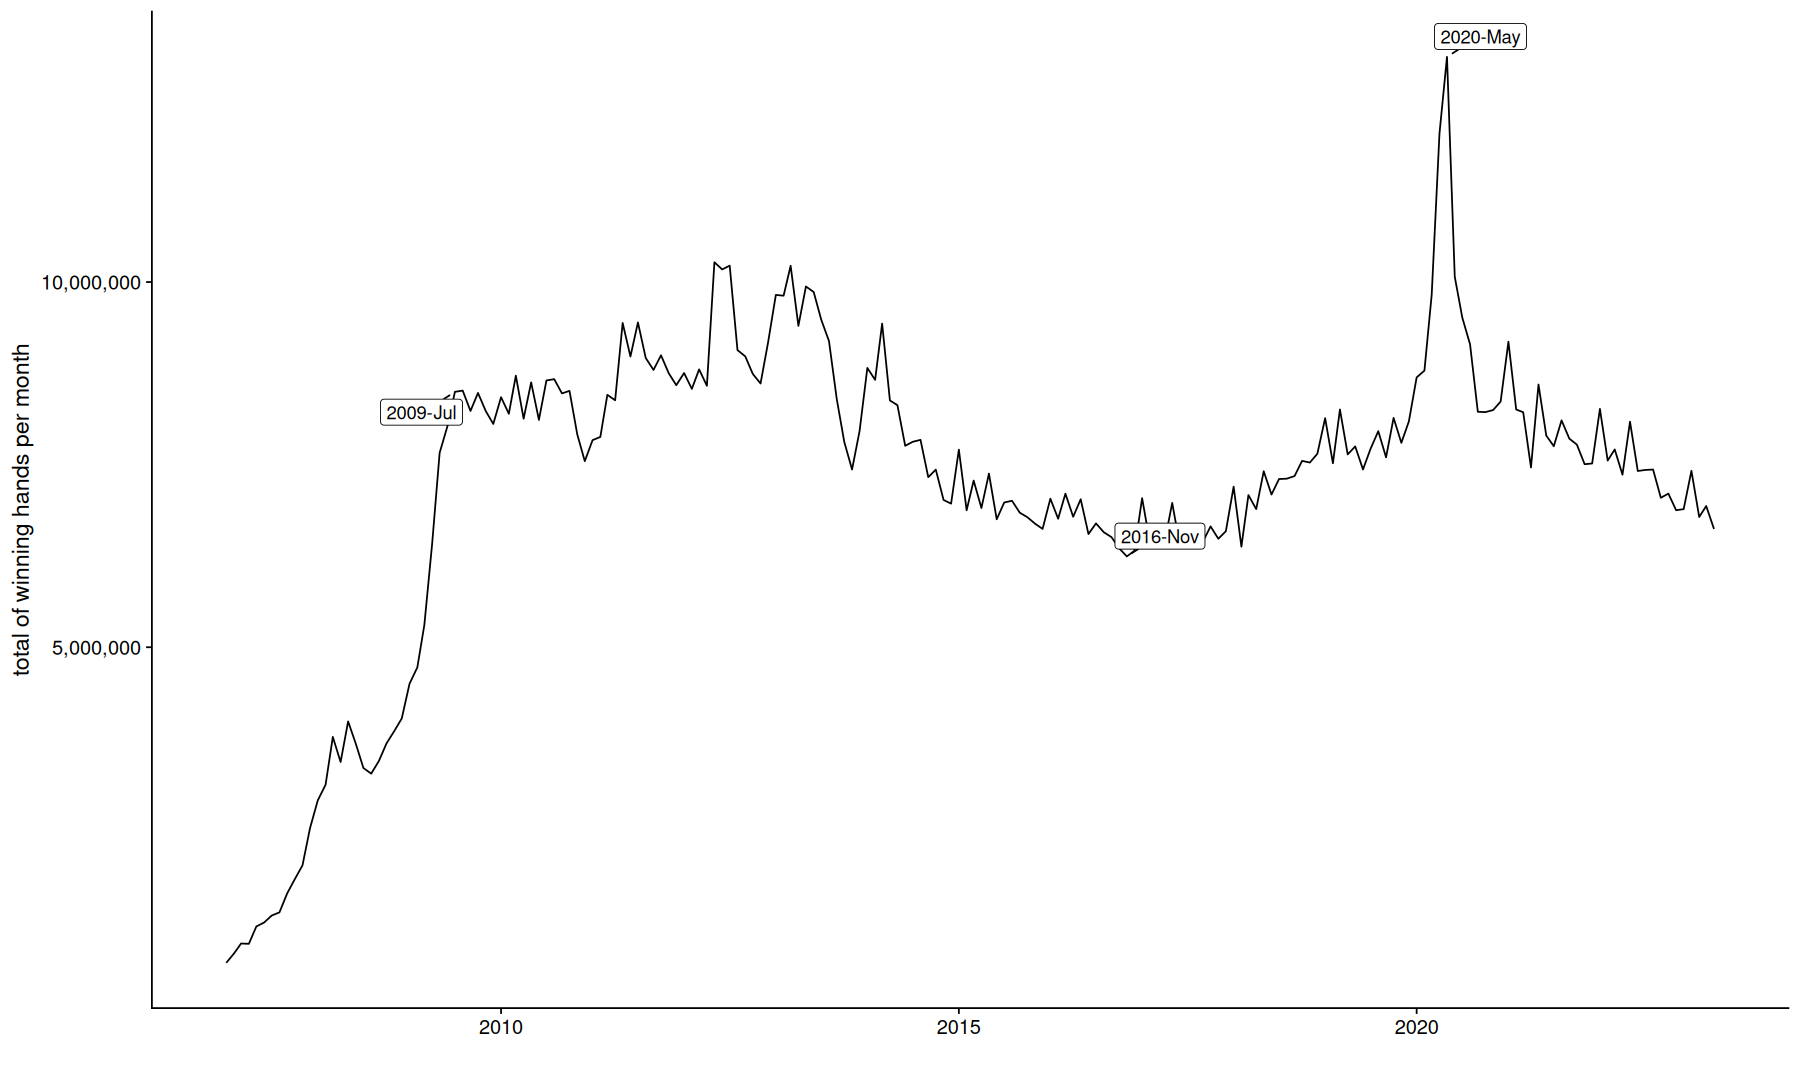

In [4]:
select(a, date, room, mode, total, n_players, n_rounds) %>% unique() %>%
group_by(date) %>% 
summarize(total=sum(total)) -> z1
filter(z1, date %in% c("2009-07-01","2016-11-01","2020-05-01")) -> z1sel
ggplot(z1,aes(x=date, y=total)) + 
geom_line() + 
scale_y_continuous(labels=scales::comma_format()) +
labs(y="total of winning hands per month", x="") +
geom_label_repel(data=z1sel, aes(label=format(date,"%Y-%b")), max.overlaps = Inf, min.segment.length = 0, segment.linetype=2)

* may-2020 had the highest number of winning hands, and is probably because a state of emergency was declared in Japan at the time due to covid-19

# game modes popularity over time

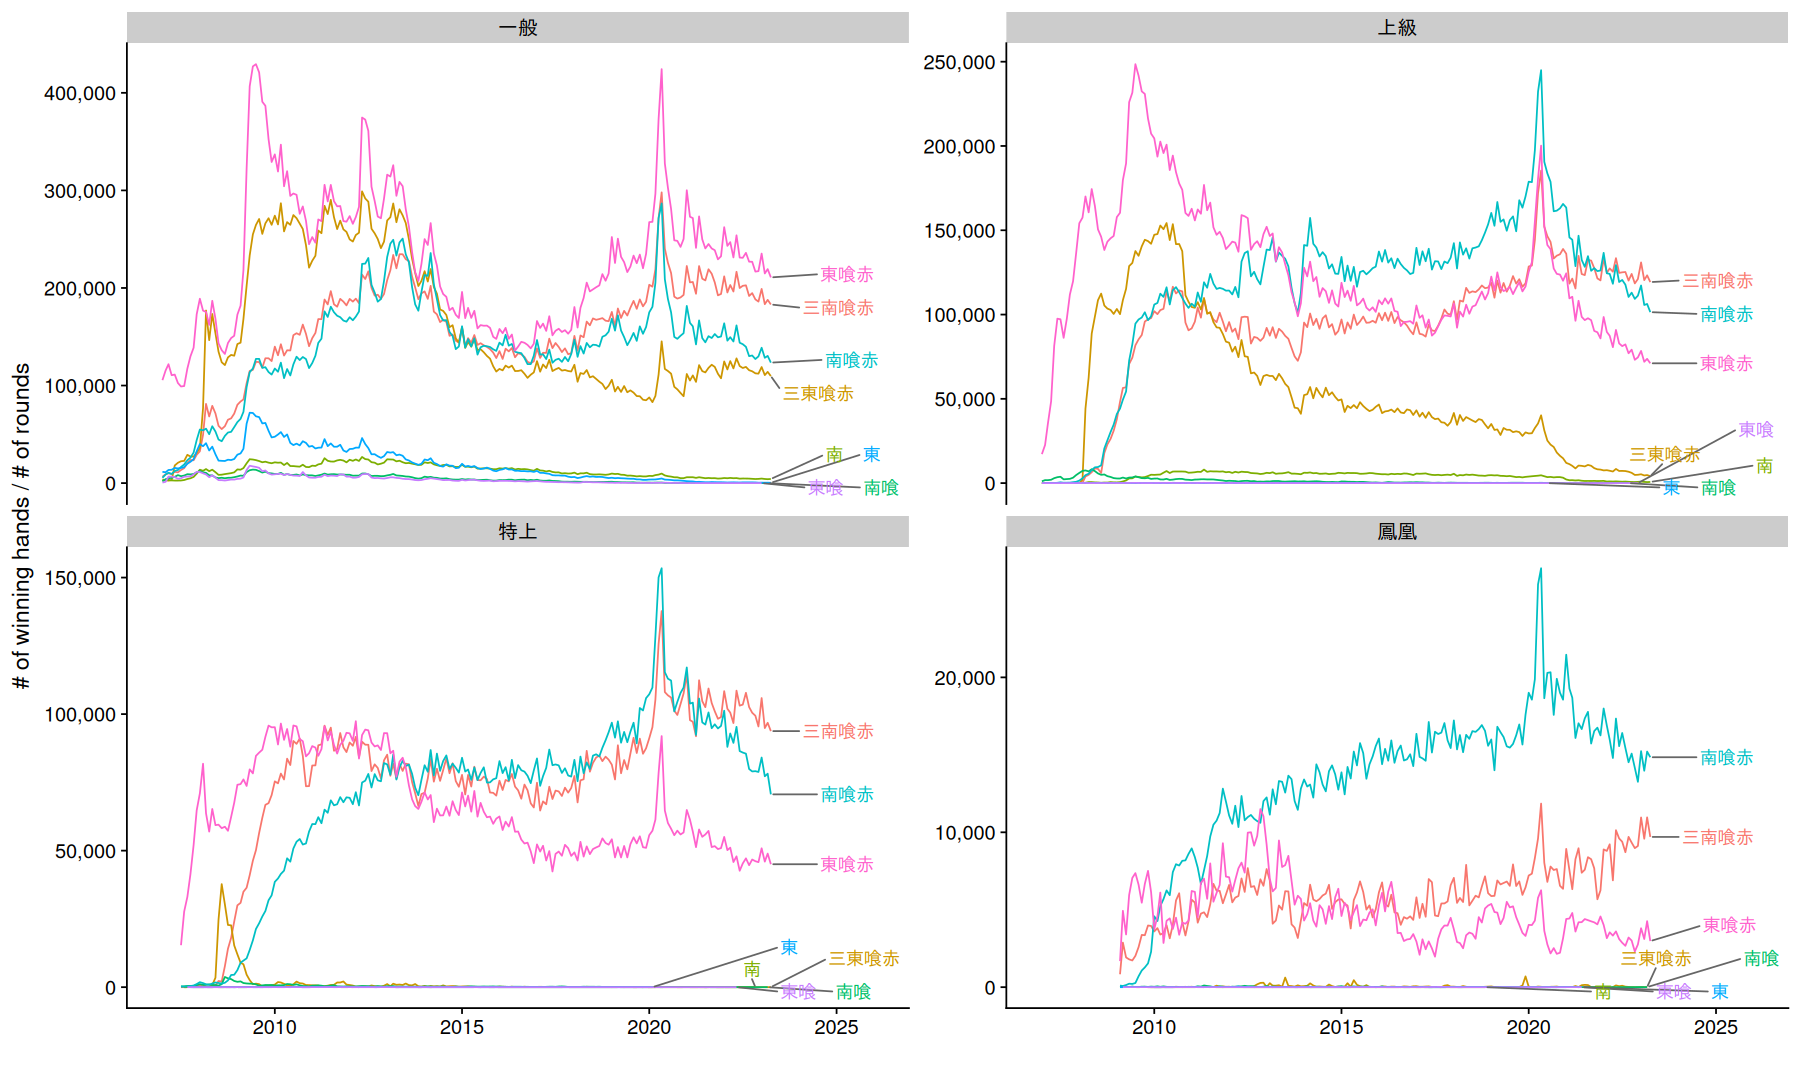

In [5]:
select(a, date, room, mode, total, n_players, n_rounds) %>% 
mutate(total_p=total/n_rounds) %>%
unique -> z1
group_by(z1, mode, room) %>% slice_max(date) -> z1max
ggplot(z1, aes(x=date, y=total_p, color=mode)) + 
geom_line() + 
scale_y_continuous(labels=scales::comma_format()) + 
geom_text_repel(data=z1max,aes(label=mode), segment.color='gray40', hjust='right', nudge_x=1000, max.iter = 1e4, min.segment.length = 0, box.padding = 0.4) +
facet_wrap(~room, scales="free_y") +
labs(y="# of winning hands / # of rounds",x="") + guides(color='none')

* modes without kuitan or akadora are the least popular option
* sanma east games are popular on ippan but on a decline in joukyuu, and inexistent in later rooms
* sanma south seems to be getting more popular in houou rooms

# yaku frequencies vs. han value

`summarise()` has grouped output by 'yaku_romaji'. You can override using the `.groups` argument.


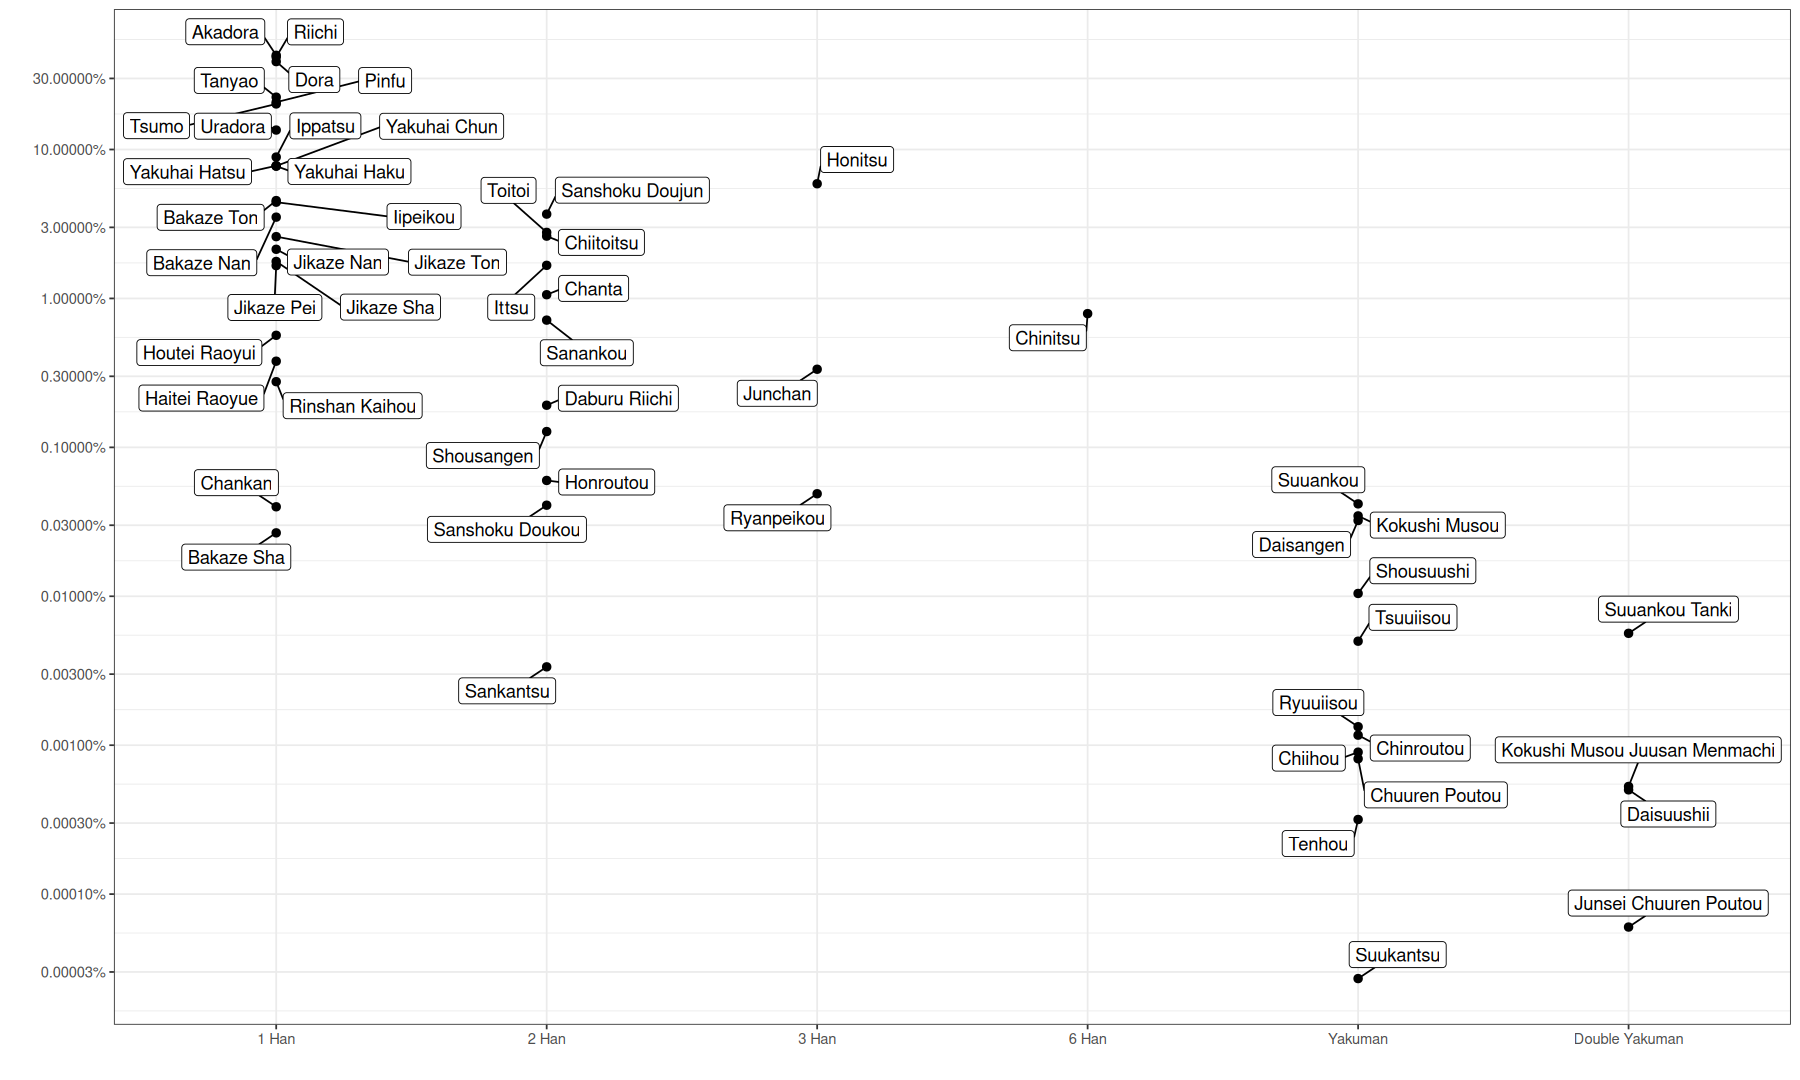

In [6]:
filter(a, mode=='南喰赤', yaku_romaji!='Bakaze Pei') %>%
group_by(yaku_romaji, han_value_closed) %>% 
summarize(count=sum(count), total=sum(total)) %>%
mutate(p=count/total) %>% arrange(-p) %>%
ggplot(aes(x=han_value_closed, y=p)) +
geom_point(size=2) + 
geom_label_repel(aes(label=yaku_romaji), min.segment.length = 0, max.iter = 1e4, max.overlaps = Inf, box.padding = 0.4) +
scale_y_log10(labels=scales::percent_format(), n.breaks=10) +
theme_bw() +
labs(y="", x="")

* the Y-axis is in log scale, the difference between one tick and the next is 3x
* sankantsu is rarer than some yakumans, suukantsu is the rarest yaku at about 1 in 3 millon winning hands
* the frequency of the yaku doesn't quite match its value, an explanation for this could be that players will tend to favor easier and/or more valuable yakus

# yaku frequencies over time

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


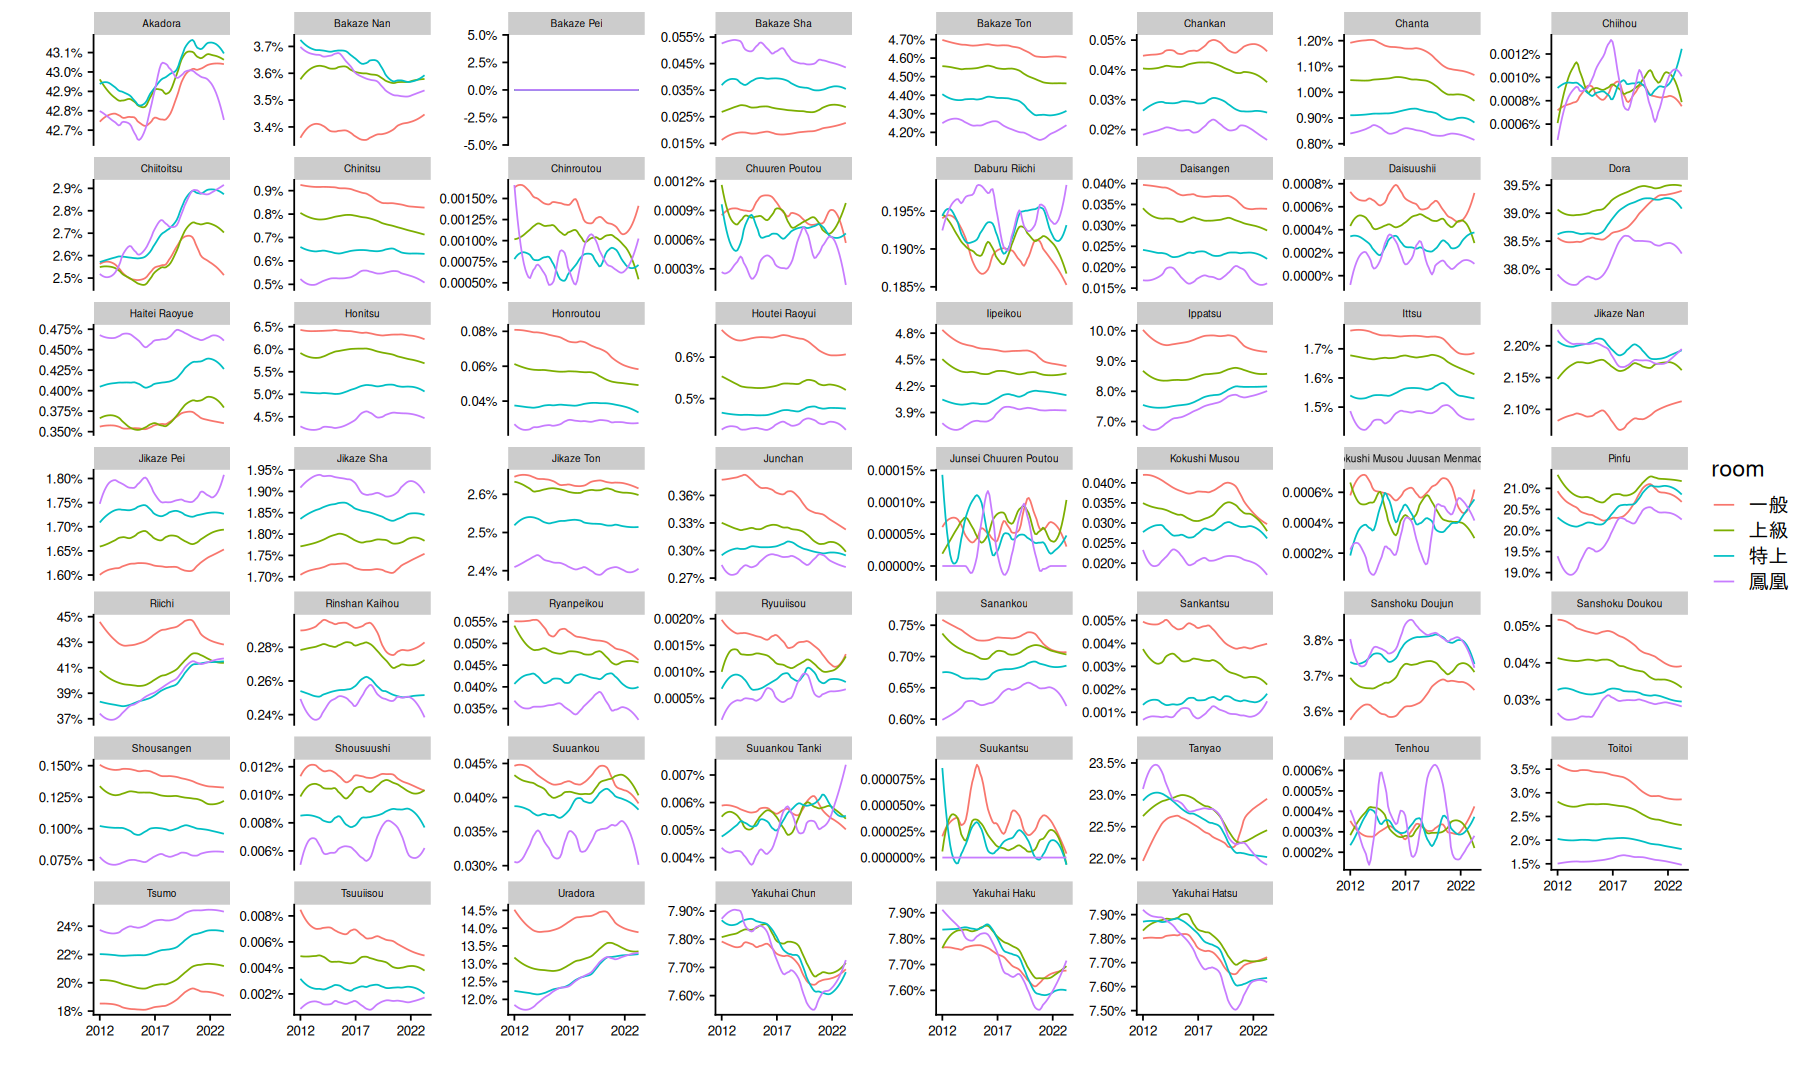

In [7]:
filter(a, mode=='南喰赤', year>2011) %>% 
mutate(rm=paste(room,mode)) %>%
ggplot(aes(x=date, y=count/total, color=room)) + 
scale_y_continuous(labels=scales::percent_format()) +
geom_smooth(se=FALSE, linewidth=0.5, span=0.3) +
labs(y="",x="") +
scale_x_date(date_labels = "%Y", breaks=as.Date(c("2012-01-01","2017-01-01","2022-01-01"))) +
facet_wrap(~yaku_romaji, scales="free_y") +
theme(
    strip.text = element_text(size = 6), 
    axis.text.y=element_text(size=8),
    axis.text.x=element_text(size=8))

* remember this is % of winning hands, the yaku chance is not changing, what changes is the way people play
* bakaze pei is weird, its super rare yes, but after 2010 it was never recorded, probably a change in the algorithm avoids a north round extension
* I removed the early years because to low amount of data makes it hard to observe the low frequencies of the rarer yakus

# average han value per yaku
doras can appear more than once on the hand, so we can look at the average amount of value contributed to the hand

Warning message:
"Removed 3 rows containing non-finite values (`stat_boxplot()`)."


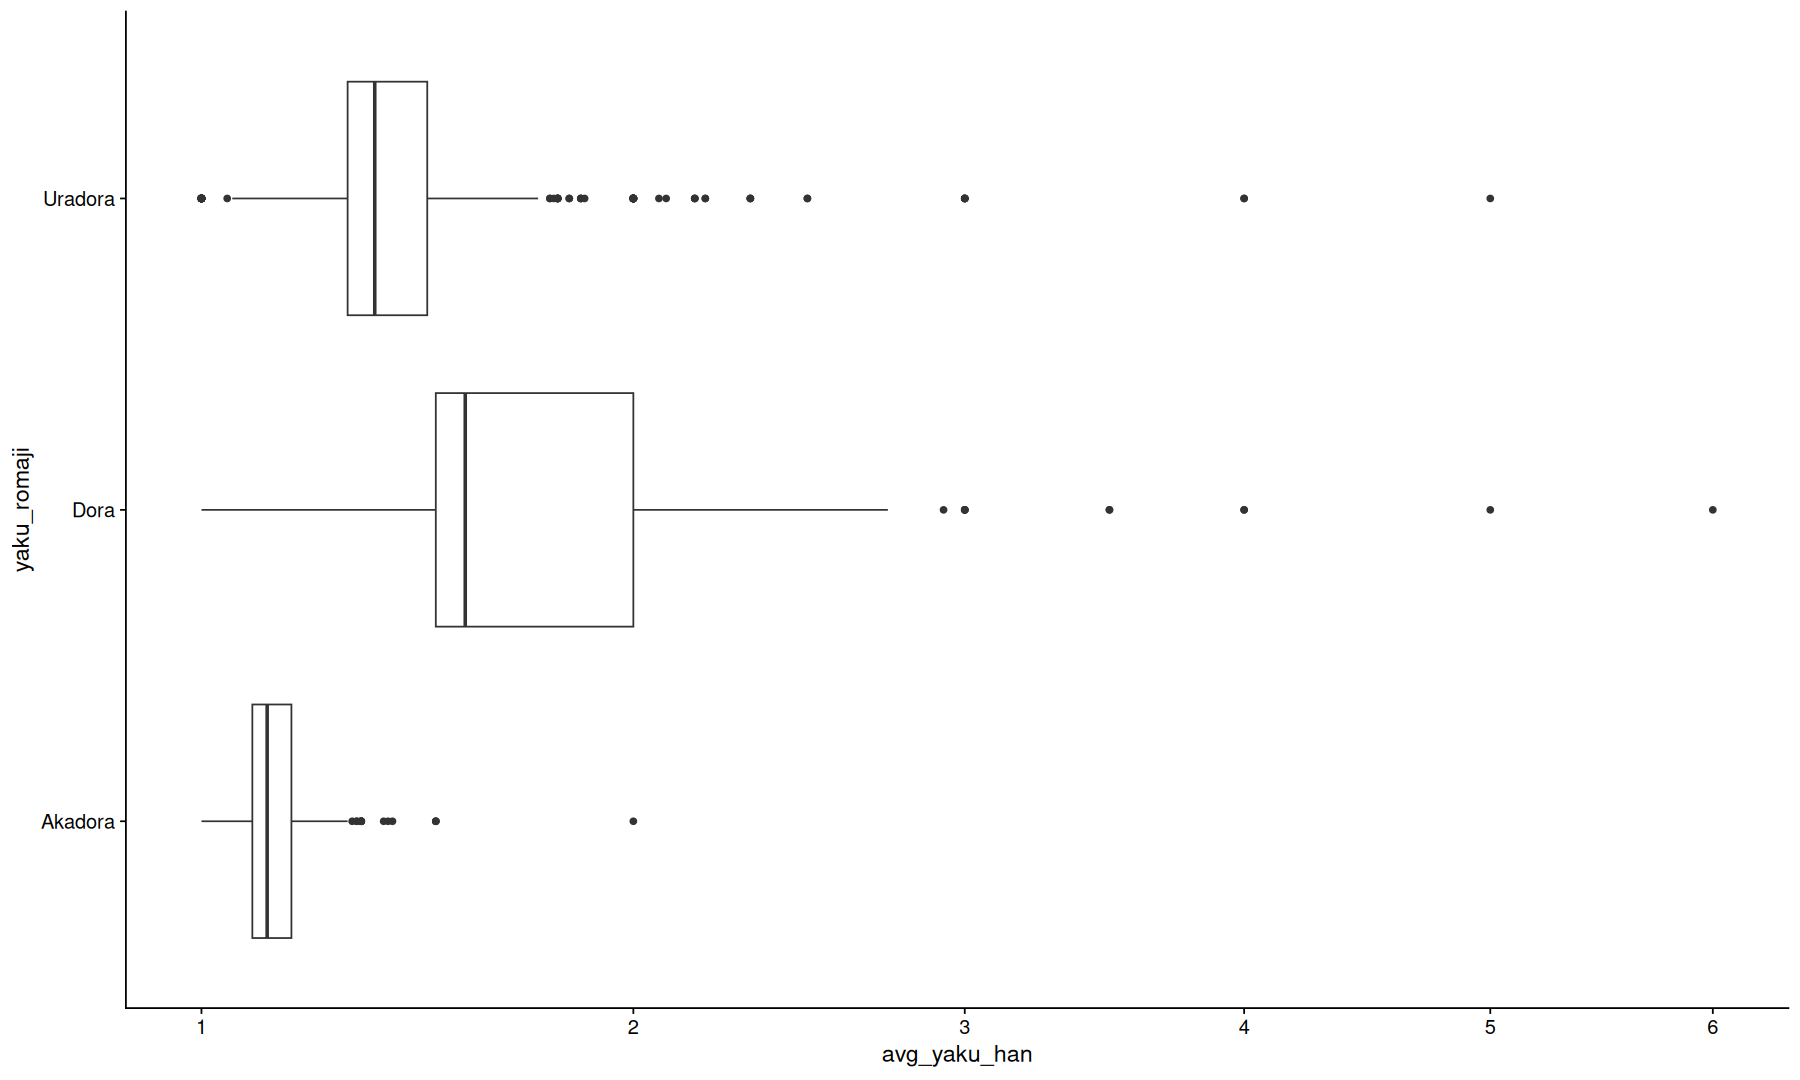

In [18]:
select(a, yaku_romaji, avg_yaku_han, avg_hand_han, han_value_closed) %>% unique %>%
filter(yaku_romaji %in% c("Dora", "Akadora", "Uradora")) %>%
ggplot(aes(x=avg_yaku_han, y=yaku_romaji)) + geom_boxplot() + scale_x_sqrt()

Warning message:
"Removed 70864 rows containing non-finite values (`stat_boxplot()`)."


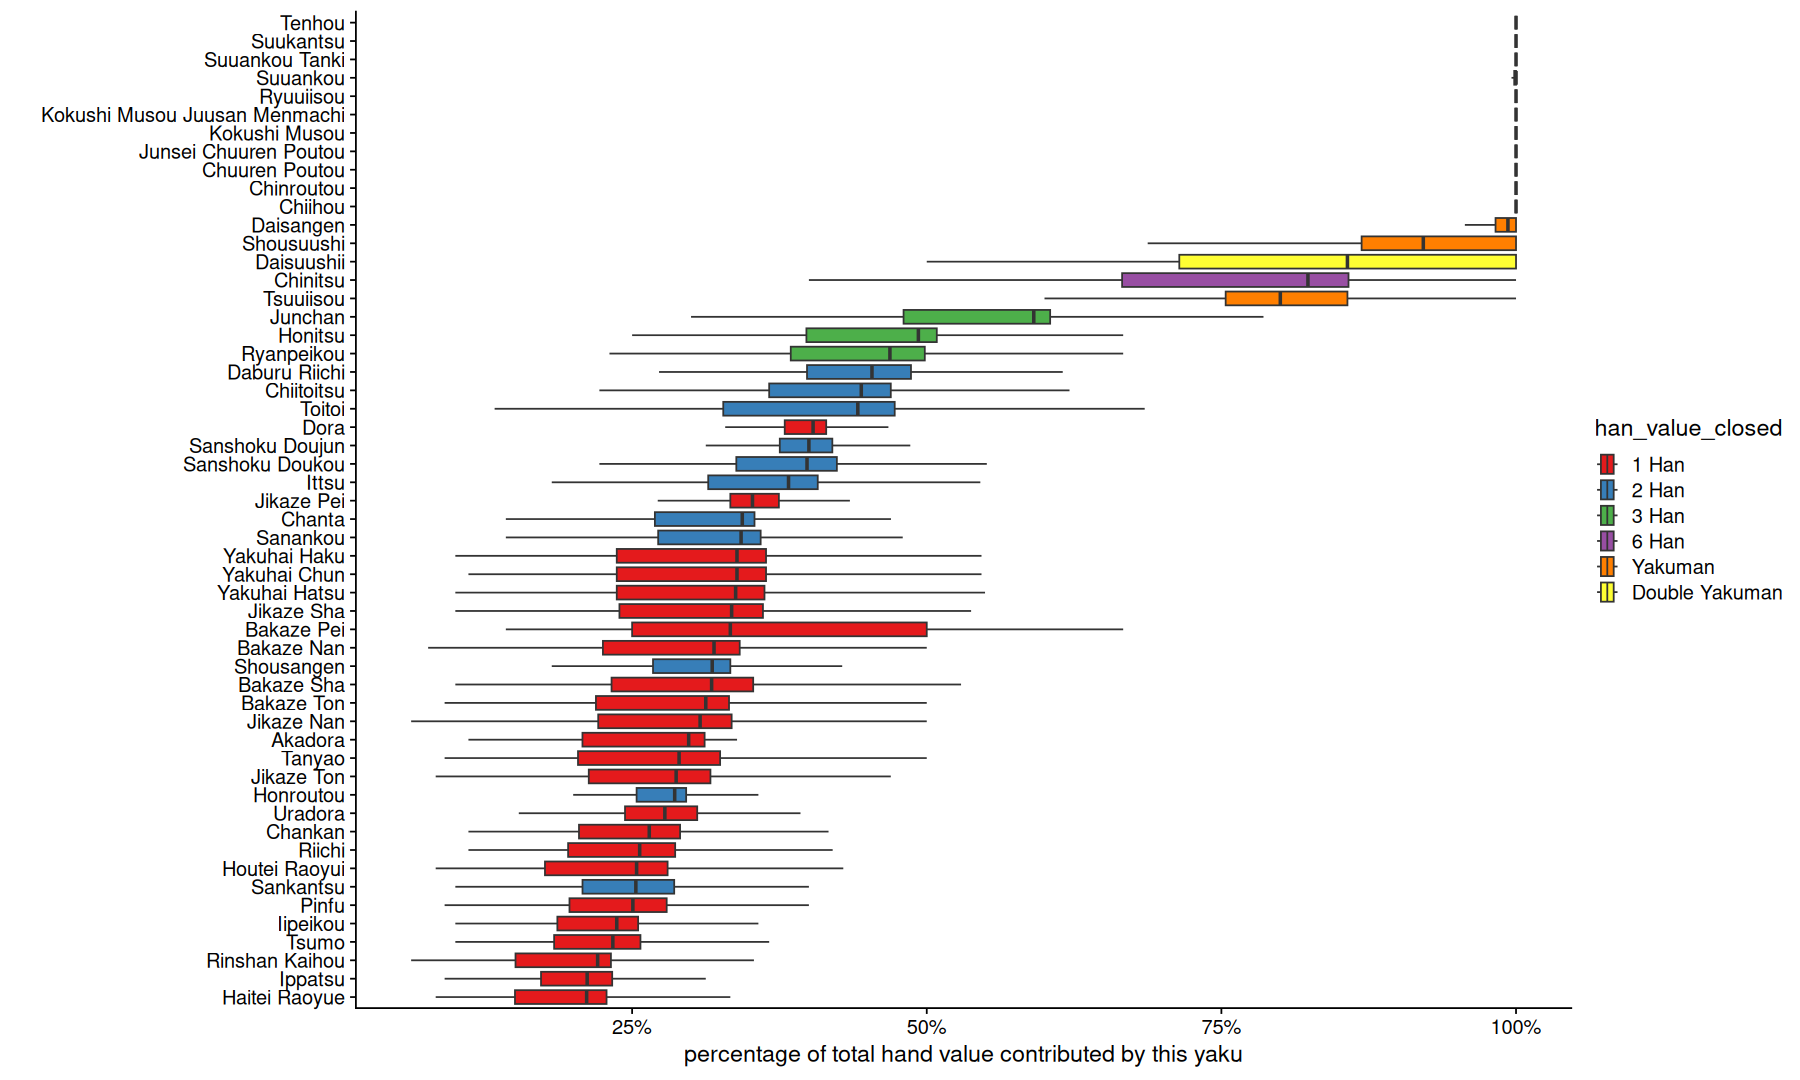

In [99]:
select(a, yaku_romaji, avg_yaku_han, avg_hand_han, han_value_closed, date, room, mode) %>% unique %>%
mutate(perc_han=avg_yaku_han/avg_hand_han) %>%
ggplot(aes(x=perc_han, y=fct_reorder(yaku_romaji, perc_han, .na_rm=TRUE), fill=han_value_closed)) + 
geom_boxplot(outlier.shape = NA) + 
scale_fill_brewer(palette='Set1') +
scale_x_continuous(labels=scales::percent_format()) +
labs(y="", x="percentage of total hand value contributed by this yaku") 

# looking at specific yakus

`summarise()` has grouped output by 'room_romaji'. You can override using the `.groups` argument.


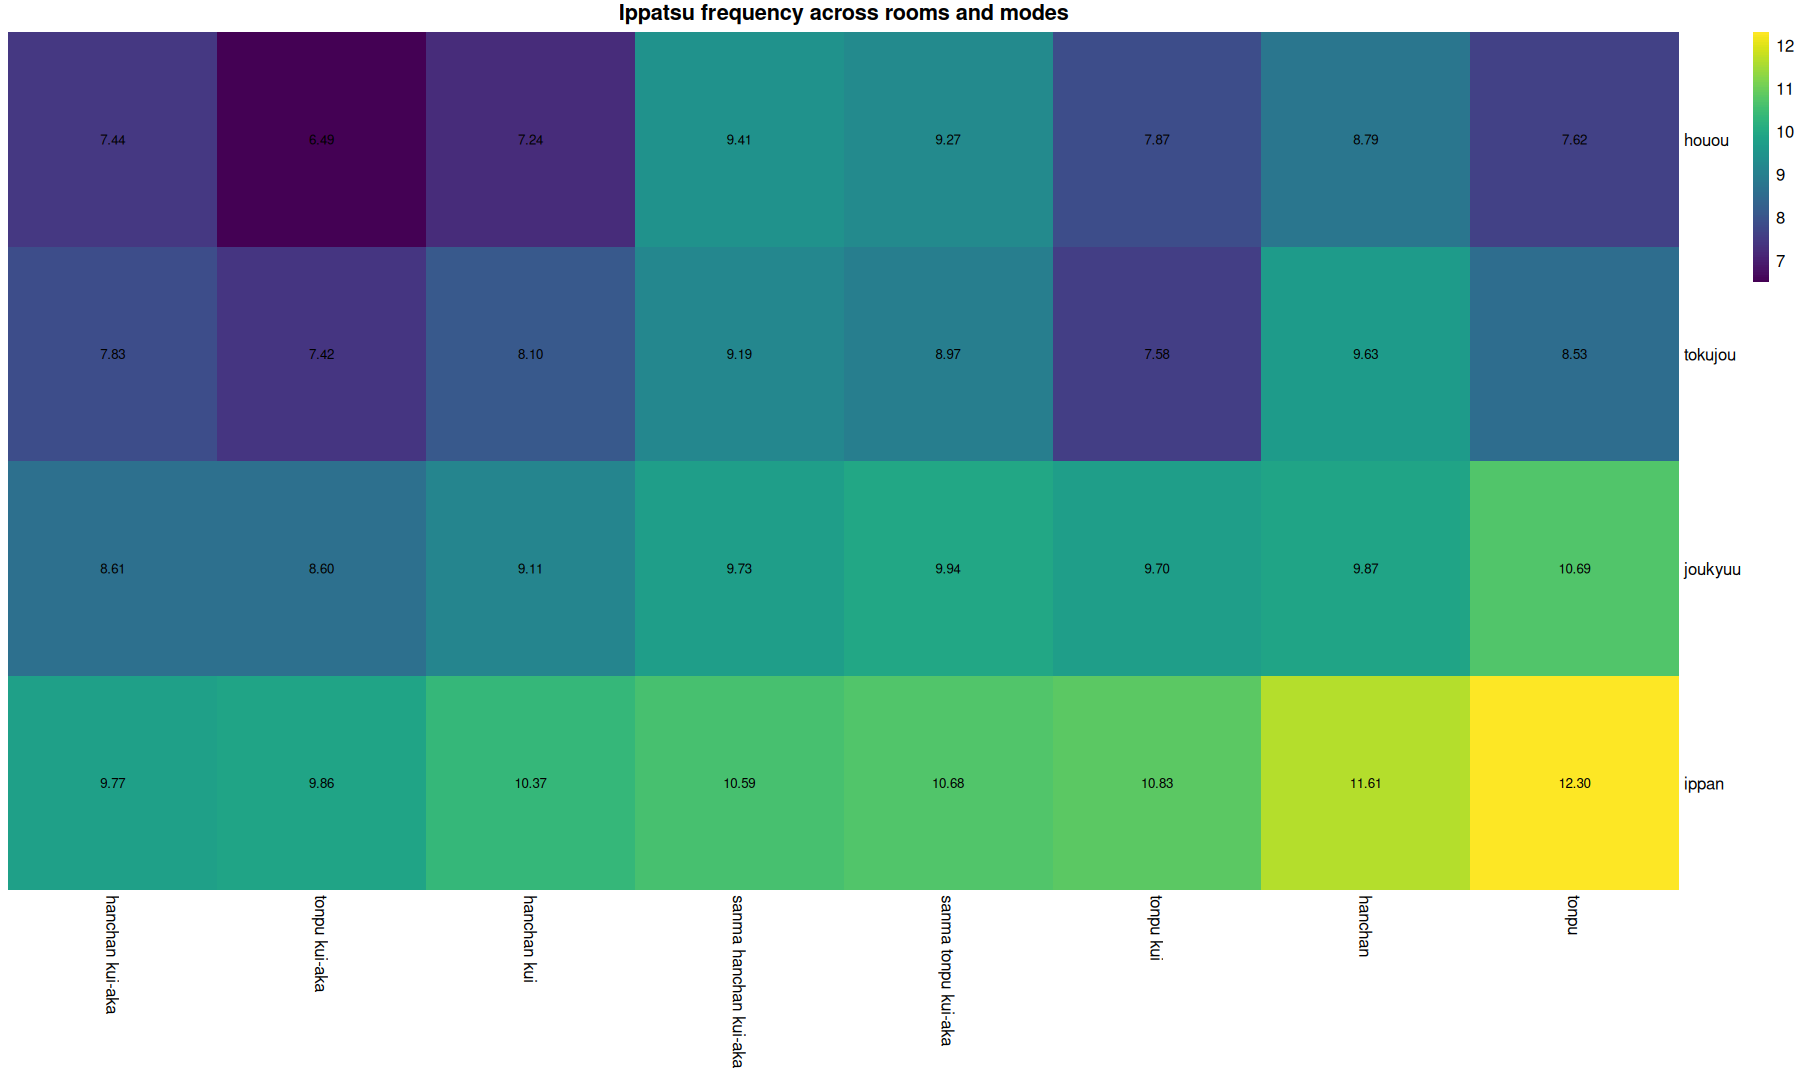

In [72]:
filter(a, yaku_romaji=='Ippatsu') %>%
group_by(room_romaji, mode_romaji) %>%
summarize(total=sum(total), count=sum(count)) %>%
mutate(p=100*count/total, total=NULL, count=NULL) %>%
mutate(room_romaji=ordered(room_romaji, levels=c("ippan", "joukyuu", "tokujou", "houou"))) %>%
pivot_wider(names_from = 'mode_romaji', values_from = 'p') %>%
arrange(room_romaji) %>%
column_to_rownames('room_romaji') %>% 
as.matrix() %>%
.[order(rowMaxs(.)),order(colMaxs(.))] %>%
pheatmap(display_numbers = TRUE,main='Ippatsu frequency across rooms and modes', color=viridis(100), number_color = 'black', cluster_rows=F, cluster_cols=F, border_color = NA)

`summarise()` has grouped output by 'room_romaji'. You can override using the `.groups` argument.


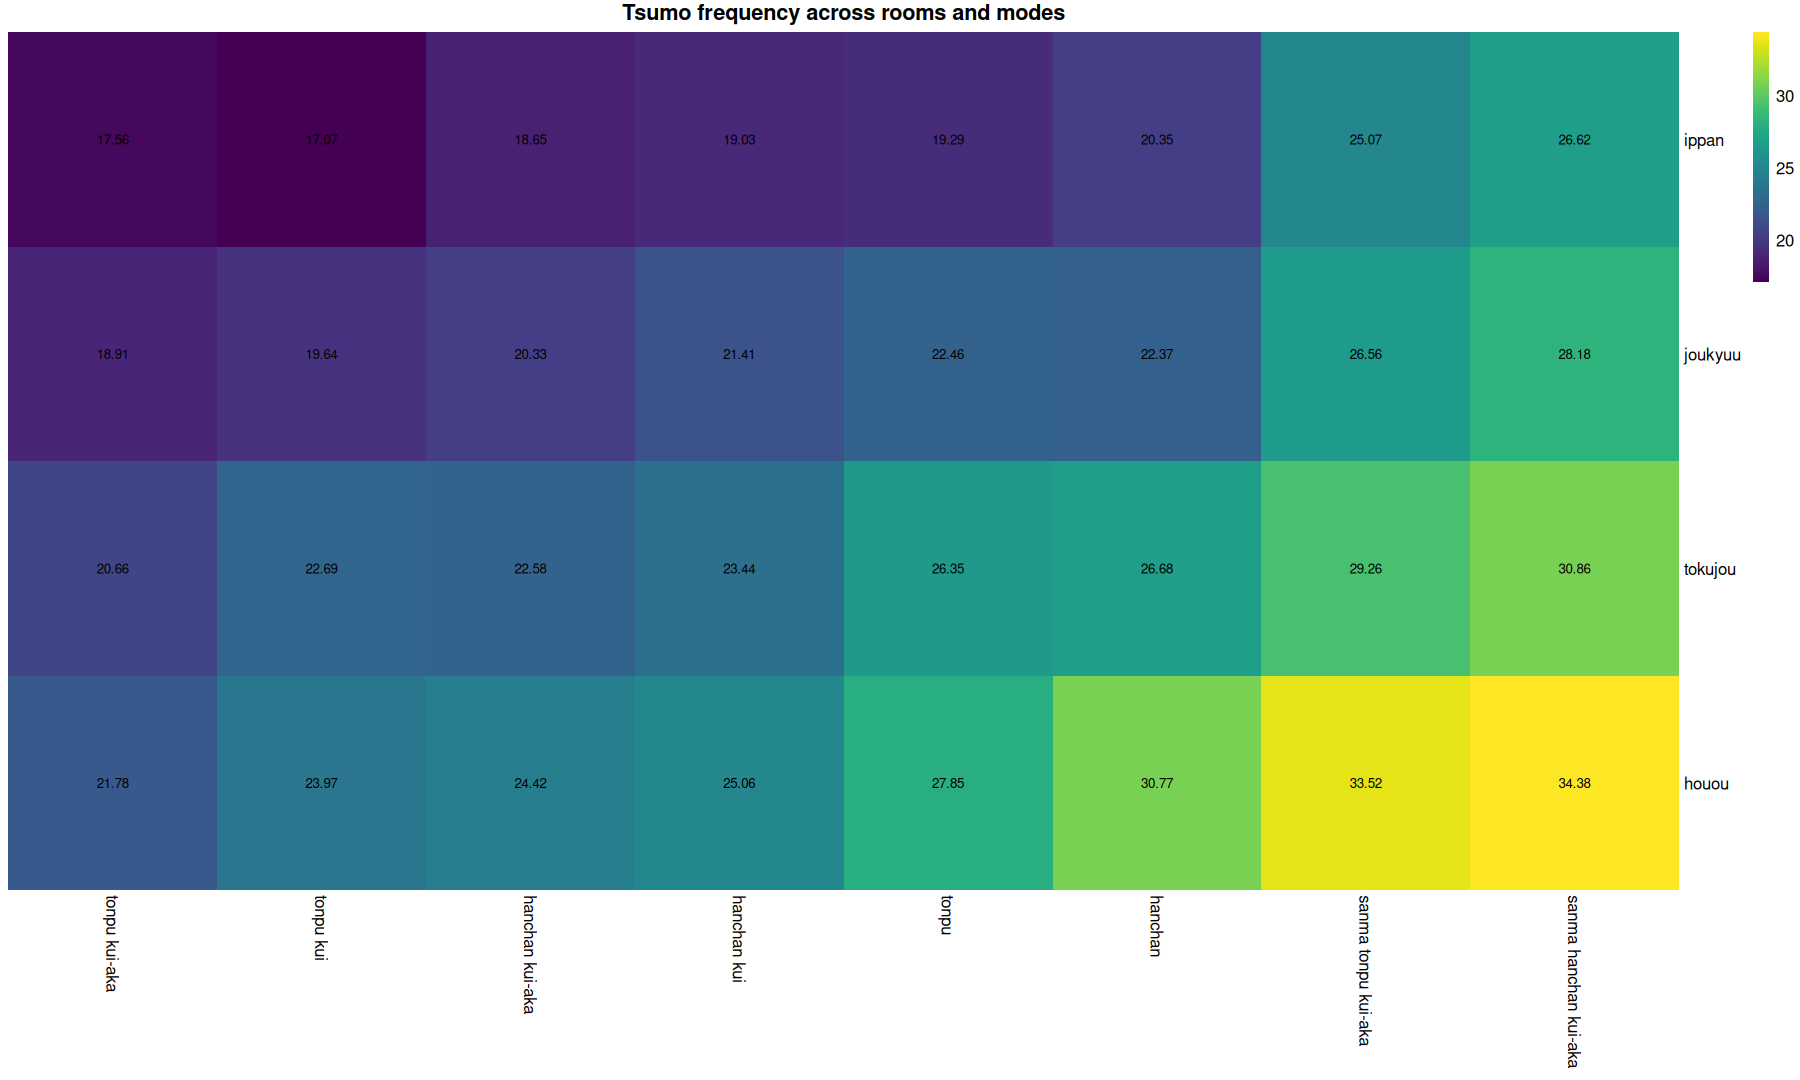

In [73]:
filter(a, yaku_romaji=='Tsumo') %>%
group_by(room_romaji, mode_romaji) %>%
summarize(total=sum(total), count=sum(count)) %>%
mutate(p=100*count/total, total=NULL, count=NULL) %>%
pivot_wider(names_from = 'mode_romaji', values_from = 'p') %>%
column_to_rownames('room_romaji') %>% 
as.matrix() %>%
.[order(rowMaxs(.)),order(colMaxs(.))] %>%
pheatmap(display_numbers = TRUE,main='Tsumo frequency across rooms and modes', color=viridis(100), number_color = 'black', cluster_rows=F, cluster_cols=FALSE, border_color = NA)

# etc

In [12]:
filter(a, avg_yaku_han>4, yaku_romaji=='Dora')

yaku,month,year,room,mode,total,count,avg_yaku_han,avg_hand_han,date,room_romaji,yaku_romaji,han_value_closed,mode_romaji,n_players,n_rounds
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<chr>,<chr>,<ord>,<chr>,<dbl>,<dbl>
ドラ,1,2014,上級,東,2,1,5,8,2014-01-01,joukyuu,Dora,1 Han,tonpu,4,4
ドラ,10,2022,特上,三東喰赤,2,1,6,10,2022-10-01,tokujou,Dora,1 Han,sanma tonpu kui-aka,3,3


Warning message:
"Removed 2269 rows containing non-finite values (`stat_binhex()`)."


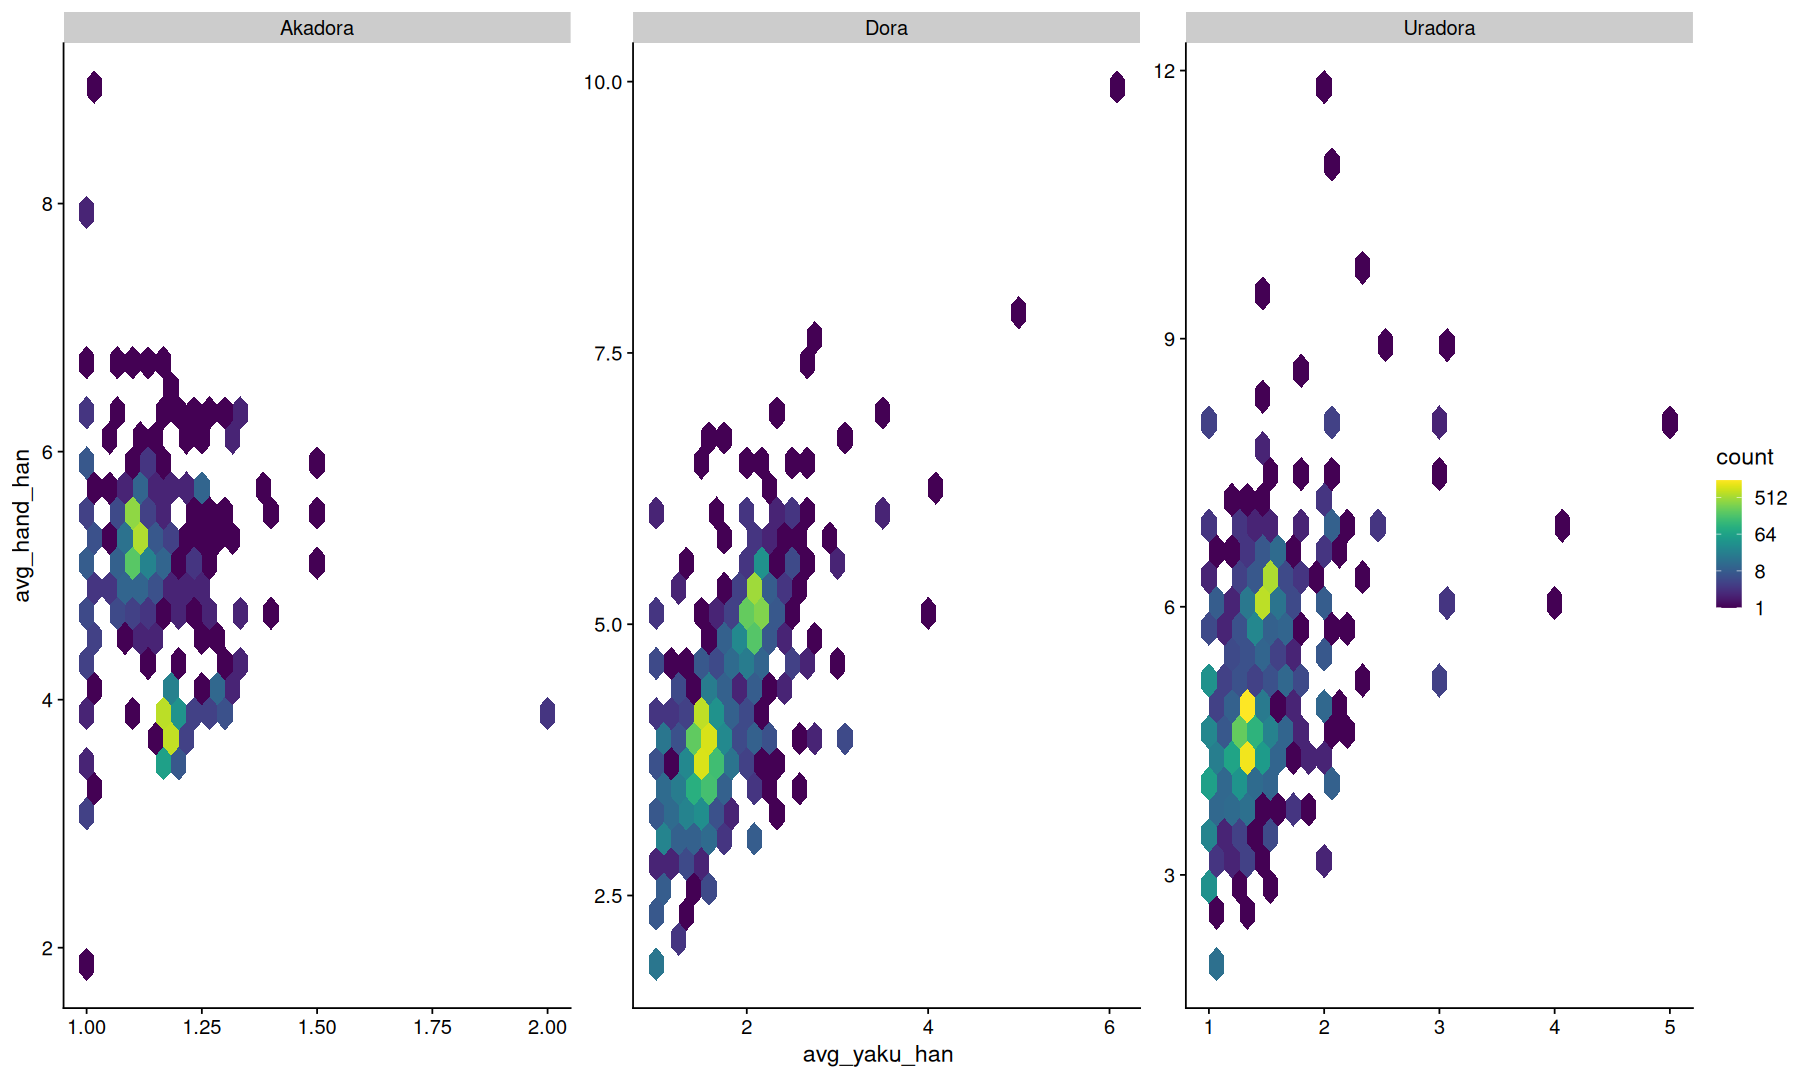

In [13]:
filter(a, yaku_romaji %in% c("Dora", "Akadora", "Uradora")) %>%
ggplot(aes(x=avg_yaku_han, y=avg_hand_han)) + geom_hex() +
scale_fill_viridis(trans='log2') + facet_wrap(~yaku_romaji, scales="free")

In [81]:
mutate(a, z=count/total * avg_yaku_han) %>% filter(total>10000) %>%
select(yaku_romaji, count, total, avg_yaku_han, avg_hand_han, date, room, mode, z) %>% unique

yaku_romaji,count,total,avg_yaku_han,avg_hand_han,date,room,mode,z
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<chr>,<chr>,<dbl>
Dora,30121,39157,2.15,5.66,2007-01-01,一般,三南喰赤,1.653858824731210
Dora,8563,11204,2.15,5.67,2007-01-01,一般,三東喰赤,1.643203320242770
Dora,8127,21206,1.56,3.93,2007-01-01,一般,南,0.597855323964916
Dora,5760,14760,1.56,3.77,2007-01-01,一般,南喰,0.608780487804878
Dora,16592,43756,1.58,4.39,2007-01-01,一般,南喰赤,0.599126062711400
Dora,17642,46241,1.57,3.93,2007-01-01,一般,東,0.598990938777276
Dora,159783,422043,1.58,4.36,2007-01-01,一般,東喰赤,0.598178716386719
Dora,26446,68752,1.55,4.27,2007-01-01,上級,東喰赤,0.596219746334652
Dora,151123,195751,2.14,5.48,2008-01-01,一般,三南喰赤,1.652115289321638


Warning message:
"Removed 70864 rows containing non-finite values (`stat_boxplot()`)."


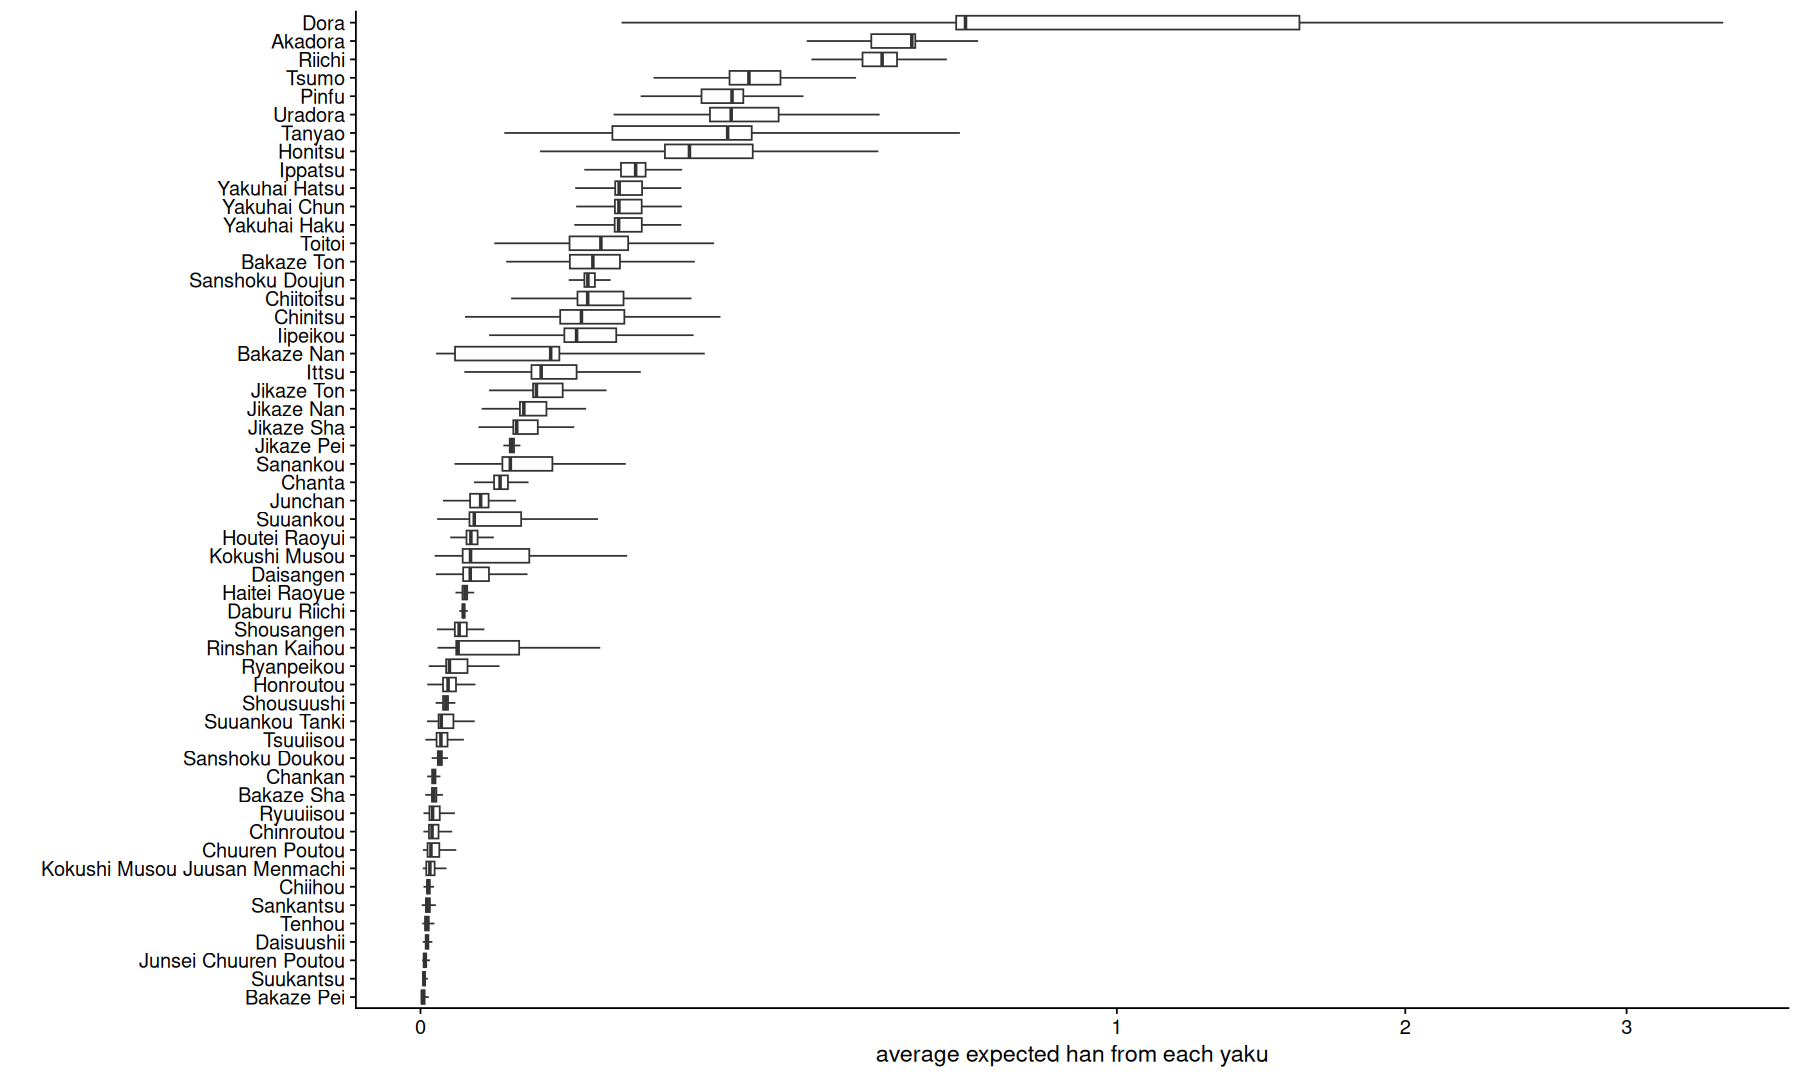

In [96]:
select(a, yaku_romaji, count, total, avg_yaku_han, avg_hand_han, date, room, mode) %>% unique %>%
mutate(avg_exp_han=count/total * avg_yaku_han) %>%
ggplot(aes(x=avg_exp_han, y=fct_reorder(yaku_romaji,avg_exp_han, .na_rm=TRUE))) + geom_boxplot(outlier.shape = NA) + 
scale_x_sqrt() +
labs(y="", x="average expected han from each yaku")

`summarise()` has grouped output by 'yaku_romaji'. You can override using the `.groups` argument.


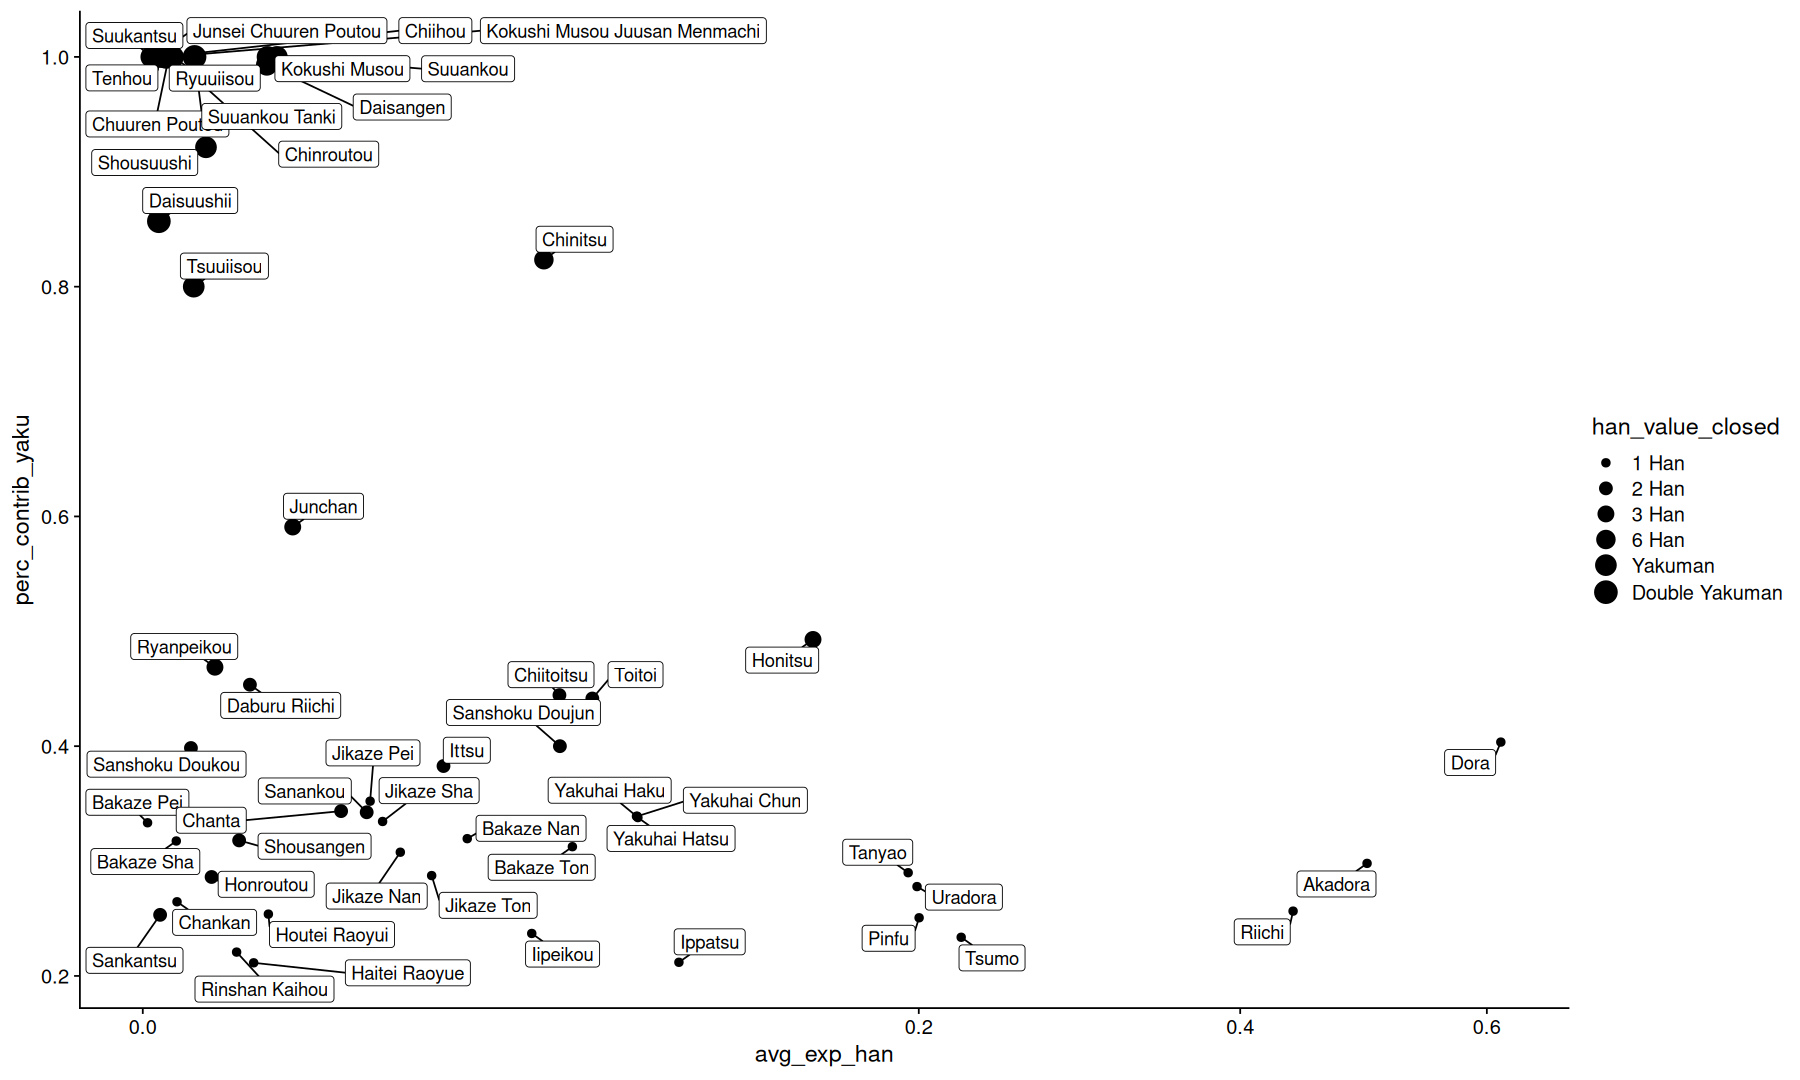

In [113]:
select(a, yaku_romaji, count, total, avg_yaku_han, avg_hand_han, date, room, mode, han_value_closed) %>% unique %>%
mutate(avg_exp_han=count/total * avg_yaku_han, perc_contrib_yaku=avg_yaku_han/avg_hand_han) %>%
group_by(yaku_romaji, han_value_closed) %>%
summarize(
    avg_exp_han=median(avg_exp_han, na.rm=TRUE),
    perc_contrib_yaku=median(perc_contrib_yaku, na.rm=TRUE)
) %>%
ggplot(aes(x=avg_exp_han, y=perc_contrib_yaku)) + 
geom_point(aes(size=han_value_closed)) +
geom_label_repel(aes(label=yaku_romaji), max.overlaps = Inf, min.segment.length = 0) + 
scale_x_sqrt()